# 📈 Storytelling: E-Commerce Data Insights

In this notebook, we will use the queries and functions from our EDA to uncover key business insights from the e-commerce database. We'll visualize trends and highlight actionable findings using Python and popular data visualization libraries.

---

## 1. Imports & Setup

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from database.database_connection import get_session
from database.models import (
    Usuario, Orden, DetalleOrden,
    MetodoPago, OrdenMetodoPago
)
from sqlalchemy import select, func, extract

session = get_session()

## 2. What day of the week has the most sales?


C:\Users\Pedro\AppData\Local\Temp\ipykernel_12384\2690089161.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_name', y='sales_count', data=df_days, palette='viridis')


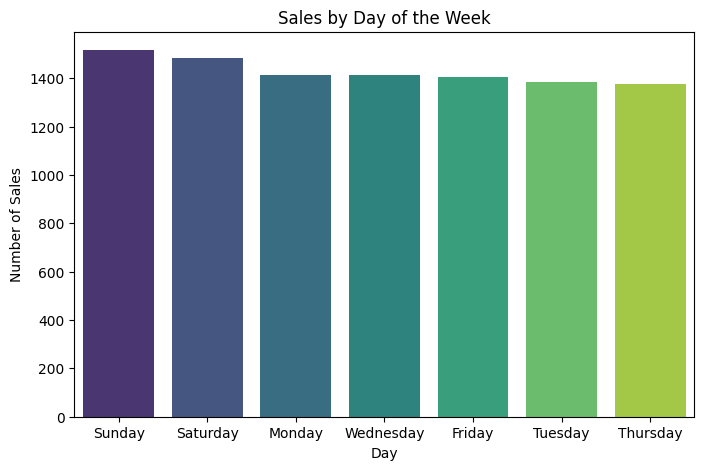

In [4]:
stmt = (
    select(
        extract('dow', Orden.fecha_orden).label('day_of_week'),
        func.count().label('sales_count')
    )
    .group_by('day_of_week')
    .order_by(func.count().desc())
)
result = session.execute(stmt).all()

days_map = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_days = pd.DataFrame(result, columns=['day_of_week', 'sales_count'])
df_days['day_name'] = df_days['day_of_week'].apply(lambda x: days_map[int(x)])

plt.figure(figsize=(8,5))
sns.barplot(x='day_name', y='sales_count', data=df_days, palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Sales')
plt.show()

Weekends are the days with the highest sales, which could be due to people having more time to shop online during those days.
Thursday has the lowest sales, so offering discounts on this day could help attract more customers.

## 3. Top Spending Users


In [ ]:
# Calcula el total de ventas usando la columna total de la tabla Orden
stmt_total = select(func.sum(Orden.total))
total_sales = session.execute(stmt_total).scalar_one()

# Calcula el gasto total por usuario usando la columna total de Orden
stmt = (
    select(
        Usuario.usuario_id,
        Usuario.nombre,
        func.sum(Orden.total).label('total_spent')
    )
    .join(Orden, Orden.usuario_id == Usuario.usuario_id)
    .group_by(Usuario.usuario_id, Usuario.nombre)
    .order_by(func.sum(Orden.total).desc())
    .limit(10)
)
result = session.execute(stmt).all()
df_users = pd.DataFrame(result, columns=['user_id', 'user_name', 'total_spent'])

# Calcula el porcentaje de ventas de cada usuario respecto al total
df_users['percent_of_total'] = df_users['total_spent'] / total_sales * 100

plt.figure(figsize=(10,6))
sns.barplot(x='user_name', y='percent_of_total', data=df_users, palette='mako')
plt.title('Top 10 Users by % of Total Sales')
plt.xlabel('User')
plt.ylabel('% of Total Sales')
plt.xticks(rotation=45)

In [21]:
print(total_sales)

7594525.94


## 4. Payment Method Distribution


C:\Users\Pedro\AppData\Local\Temp\ipykernel_12384\2655384574.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='payment_method', x='count', data=df_payments, palette='crest', orient='h')


Text(0.5, 0, 'Number of Orders')

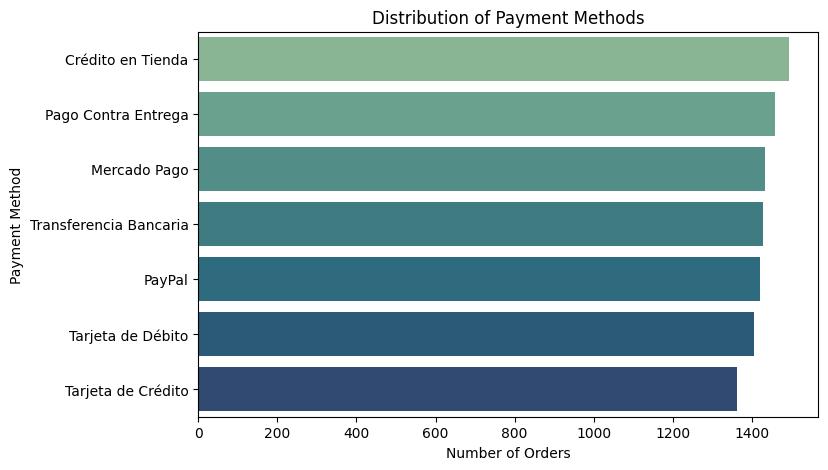

In [13]:
stmt = (
    select(MetodoPago.nombre, func.count().label("count"))
    .select_from(OrdenMetodoPago)
    .join(MetodoPago, OrdenMetodoPago.metodo_pago_id == MetodoPago.metodo_pago_id)
    .group_by(MetodoPago.nombre)
)
result = session.execute(stmt).all()
df_payments = pd.DataFrame(result, columns=['payment_method', 'count'])

# Sort by count descending
df_payments = df_payments.sort_values(by='count', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(y='payment_method', x='count', data=df_payments, palette='crest', orient='h')
plt.title('Distribution of Payment Methods')
plt.ylabel('Payment Method')
plt.xlabel('Number of Orders')

El credito en tienda fue el medio de pago mas usado.

Se puede deber a que los clientes lo ven como "dinero gratis".

----

## Conclusión
El dataset presenta una distribución de datos muy homogénea, lo cual limita la posibilidad de detectar patrones o insights significativos. Incluir cierta variabilidad o “ruido” controlado podría haber facilitado un análisis más rico y realista.